In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino
## L04 - SVM, KNN

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.25

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [4]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of 
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()
        
    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.05
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)
    
    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [5]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):
    
    """Plot the decision function for a 2D SVC"""
    
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    
    Y, X = np.meshgrid(y, x)
    
    P = np.zeros_like(X)
    
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [6]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes 
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [7]:
#Make predictions using Support Vector Machines
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

clf = SVC(kernel='linear')

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=RANDOM_STATE, cluster_std=0.60)

clf.fit(X,y)

SVC(kernel='linear')

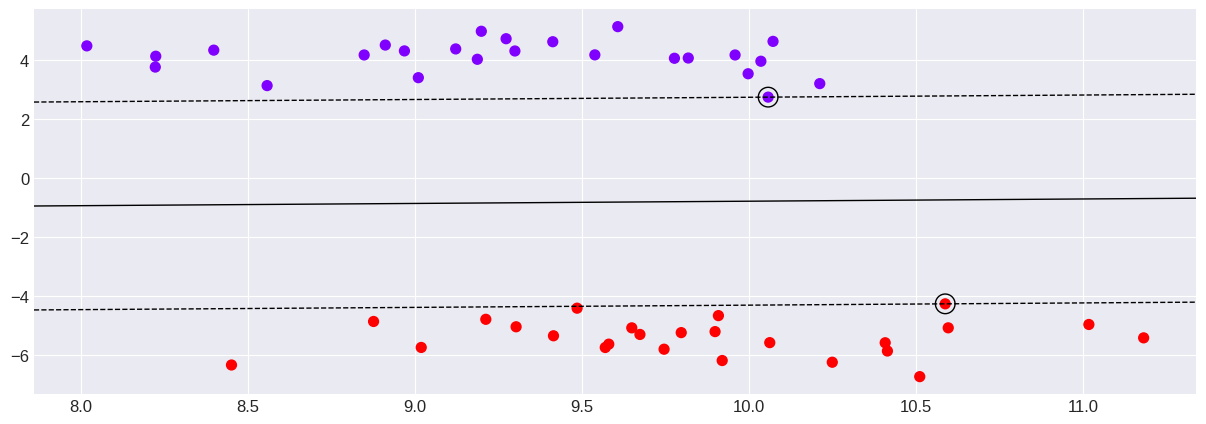

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=CMAP) 

plt.scatter(clf.support_vectors_[:, 0], 
            clf.support_vectors_[:, 1],
            s=200, edgecolors='k', facecolor = 'none');

fn_plot_svc_decision_function(clf);

## Parameter Tuning
Support vector Machines have a number of tunable parameters. Frequently used ones are :
- Kernel
- C
- Gamma

So, far we have used only kernal = 'linear' which uses “one-against-one” approach (Knerr et al., 1990). Other kernals are ‘poly’, ‘rbf(Radial Basis Function)’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used..

C Value
Let's try to plot using three values of C ; 0.001, 1, 1000 with linear Kernel.



In [9]:
# CSV file name
iris_file = os.path.join(inpDir, moduleDir, 'iris.csv')

# Define feature names

iris_features = ['sepal length',
                 'sepal width',
                 'petal length',
                 'petal width',
                 'target']
# Read the CSV file
iris_df = pd.read_csv(iris_file, sep=',', skiprows=1, 
                      header=None, names = iris_features)

target_names = ['setosa','versicolor','virginica']

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: target_names[int(i)])

iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
features = iris_df.drop('target', axis = 1)
labels = iris_df['target']

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

In [12]:
# For convenience, create a function to plot
def plot_hyplane(classifier, features, labels, i):
    plt.subplot(1, 3, i )
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    pred = classifier.predict(features)
    
    x_min, x_max = features[:, 0].min() - .1, features[:, 0].max() + .1
    y_min, y_max = features[:, 1].min() - .1, features[:, 1].max() + .1

    xx, yy = np.meshgrid ( np.linspace ( x_min, x_max, 1000 ),
                       np.linspace ( y_min, y_max, 1000))
    Z = classifier.predict ( np.c_[ xx.ravel(), yy.ravel()])

    # Plot the decision surface
    Z = Z.reshape( xx.shape )
    plt.grid(False)
    plt.pcolormesh(xx, yy, Z, cmap = plt.cm.Set3 ) # refer http://matplotlib.org/users/colormaps.html

    # Plot also the training points
    plt.scatter( features [ :, 0], features [ :, 1], c = labels,
            cmap=plt.cm.flag)

    plt.axis('tight')

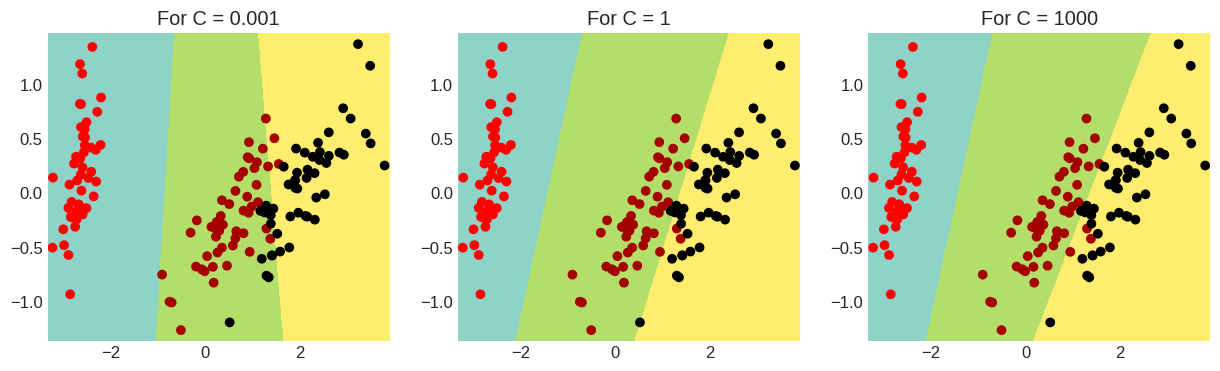

In [13]:
plt.figure( figsize = (15,4) )
#C_values = [1e-3, 1, 1e3]
C_values = [0.001, 1, 1000]

i = 1

for C in C_values:
    clf = SVC(kernel='linear', C = C)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title('For C = {}'.format(C))
    
plt.show()

## Kernel

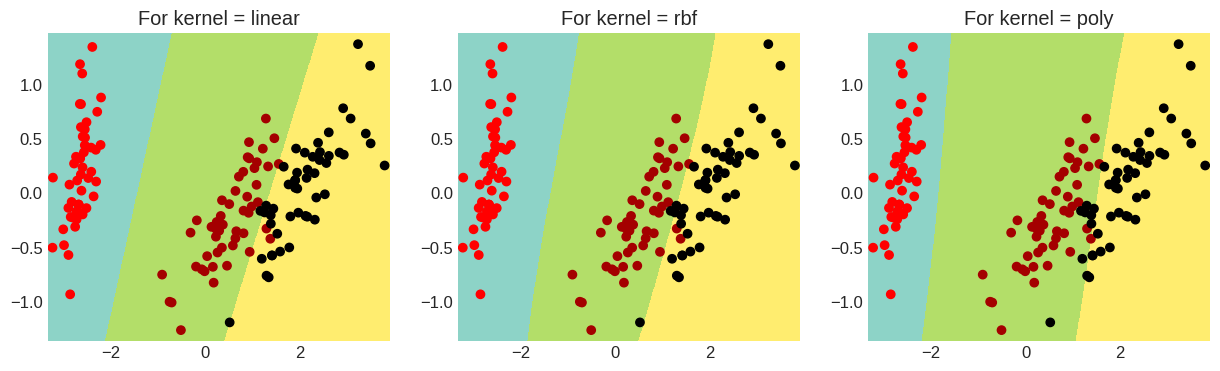

In [14]:
plt.figure( figsize = (15,4) )
kernels = ['linear', 'rbf', 'poly']

i = 1

for k in kernels:
    clf = SVC(kernel=k)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title('For kernel = {}'.format(k))
    plt.axis('tight')
#plt.savefig('../images/22_svm_kernel.jpg')
plt.show()

## Gamma

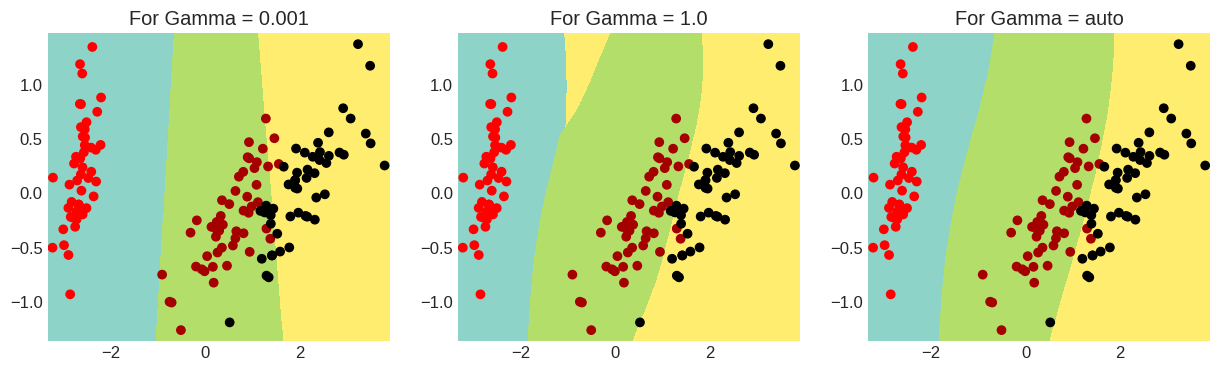

In [16]:
plt.figure( figsize = (15,4) )
gammas = [1e-3, 1.0, 'auto']

i = 1

for g in gammas:
    clf = SVC(kernel='rbf', gamma = g)
    clf.fit(pca_features, labels)

    plot_hyplane(clf, pca_features, labels, i)
    i +=1
    plt.title( 'For Gamma = {}'.format(g))
    plt.axis('tight')
#plt.savefig('../images/22_svm_gamma.jpg')
plt.show()

### Working on digits data

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
SVC: kernel : linear  | F1 Score :  0.9801
SVC: kernel : rbf     | F1 Score :  0.9844
SVC: kernel : poly    | F1 Score :  0.9889


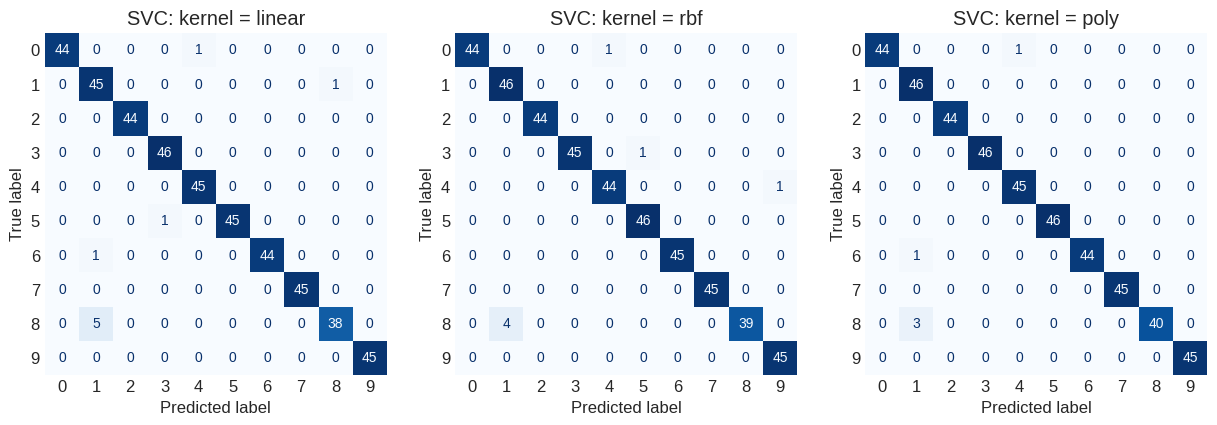

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()

print(digits.keys())

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, 
    digits.target, 
    stratify=digits.target, 
    random_state=RANDOM_STATE)

fig, axes = plt.subplots(1,3, figsize = (15,8))

for i, kernel in enumerate(['linear', 'rbf', 'poly']):
    clf = SVC(kernel=kernel).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("SVC: kernel : {: <7}".format(kernel), end = ' | ')
    print("F1 Score : {: .4f}".format(f1_score(y_test, y_pred, average='weighted')))
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

    disp.plot(ax = axes[i], cmap=plt.cm.Blues, colorbar=False);
    axes[i].set_title("SVC: kernel = {0}".format(kernel))
    axes[i].grid()
plt.show()